In [ ]:
from google.colab import files
files.upload()

In [2]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/

In [ ]:
!kaggle competitions download -c dogs-vs-cats

In [ ]:
!unzip dogs-vs-cats.zip -d dogs_vs_cats

In [5]:
import logging
import zipfile
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV ,StratifiedShuffleSplit ,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import expon

In [6]:
import zipfile

zip_files = {
    'train.zip': '/content/dogs_vs_cats/train.zip',
    'test1.zip': '/content/dogs_vs_cats/test1.zip',
}

for zip_file, extract_to in zip_files.items():
    # Ensure the extraction directory exists
    extract_dir = f'/content/dogs_vs_cats/{extract_to}'
    os.makedirs(extract_dir, exist_ok=True)

    # Extract the zip file
    with zipfile.ZipFile(f'/content/dogs_vs_cats/{zip_file}', 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
        print(f'Extracted {zip_file} to {extract_dir}')

Extracted train.zip to /content/dogs_vs_cats//content/dogs_vs_cats/train.zip
Extracted test1.zip to /content/dogs_vs_cats//content/dogs_vs_cats/test1.zip


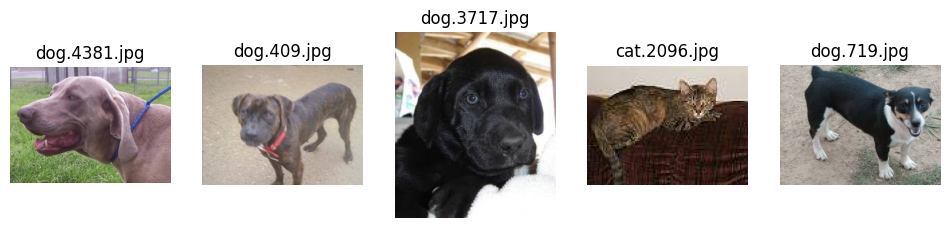

In [7]:
train_dir = '/content/dogs_vs_cats/content/dogs_vs_cats/train.zip/train'
test_dir = '/content/dogs_vs_cats/content/dogs_vs_cats/test1.zip/test1'

all_files = os.listdir(train_dir)

def is_image(file_path):
    try:
        Image.open(file_path)
        return True
    except IOError:
        return False

image_files = [f for f in all_files if is_image(os.path.join(train_dir, f))]


plt.figure(figsize=(12, 6))
for i, file_name in enumerate(image_files[:5]):  # Display first 5 images
    try:
        img_path = os.path.join(train_dir, file_name)
        img = Image.open(img_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.title(file_name)
        plt.axis('off')
    except Exception as e:
        print(f"Error loading image {file_name}: {e}")
plt.show()

In [8]:
import os

def count_images(directory):
    return len([f for f in os.listdir(directory) if f.endswith('.jpg')])

num_images = count_images(train_dir)
num_test = count_images(test_dir)
print(f"Number of images: {num_images}")
print(f"Number of images: {num_test}")

Number of images: 25000
Number of images: 12500


In [9]:
train_dir = '/content/dogs_vs_cats/content/dogs_vs_cats/train.zip/train'
test_dir = '/content/dogs_vs_cats/content/dogs_vs_cats/test1.zip/test1'
img_size = 64

def load_images(directory):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            img = cv2.imread(os.path.join(directory, filename))
            img = cv2.resize(img, (img_size, img_size))
            images.append(img)
            if 'cat' in filename:
                labels.append(0)
            else:
                labels.append(1)
    return np.array(images), np.array(labels)

X, y = load_images(train_dir)
X = X / 255.0
X = X.reshape(X.shape[0], -1)

# Stratified Subsampling
subset_size = 5000  # Adjust the subset size as needed
sss = StratifiedShuffleSplit(n_splits=1, test_size=subset_size, random_state=0)

for train_index, test_index in sss.split(X, y):
    X_subset, y_subset = X[test_index], y[test_index]

X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.1, random_state=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Dimensionality Reduction
pca = PCA(n_components=75)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [10]:
# Initialize SVM model
svm_model = svm.SVC(kernel='linear', gamma='scale')

# Train SVM model
svm_model.fit(X_train_pca, y_train)

# Make predictions
y_pred = svm_model.predict(X_test_pca)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 61.00%
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.63      0.62       251
           1       0.61      0.59      0.60       249

    accuracy                           0.61       500
   macro avg       0.61      0.61      0.61       500
weighted avg       0.61      0.61      0.61       500



In [22]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

param_dist = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}

halving_search = HalvingRandomSearchCV(
    estimator=svm.SVC(),
    param_distributions=param_dist,
    factor=2,
    min_resources=40,
    aggressive_elimination=True,
    n_jobs=-1,
    verbose=2,
    random_state=0,
    cv=2,
    max_resources=1200
    )
halving_search.fit(X_train_pca, y_train)

print(halving_search.best_params_)
print(f"Best accuracy: {halving_search.best_score_ * 100:.2f}%")


n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 40
max_resources_: 1200
aggressive_elimination: True
factor: 2
----------
iter: 0
n_candidates: 16
n_resources: 40
Fitting 2 folds for each of 16 candidates, totalling 32 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 16 is smaller than n_iter=30. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


----------
iter: 1
n_candidates: 8
n_resources: 80
Fitting 2 folds for each of 8 candidates, totalling 16 fits
----------
iter: 2
n_candidates: 4
n_resources: 160
Fitting 2 folds for each of 4 candidates, totalling 8 fits
----------
iter: 3
n_candidates: 2
n_resources: 320
Fitting 2 folds for each of 2 candidates, totalling 4 fits
----------
iter: 4
n_candidates: 1
n_resources: 640
Fitting 2 folds for each of 1 candidates, totalling 2 fits
{'kernel': 'rbf', 'gamma': 'auto', 'C': 100}
Best accuracy: 53.75%


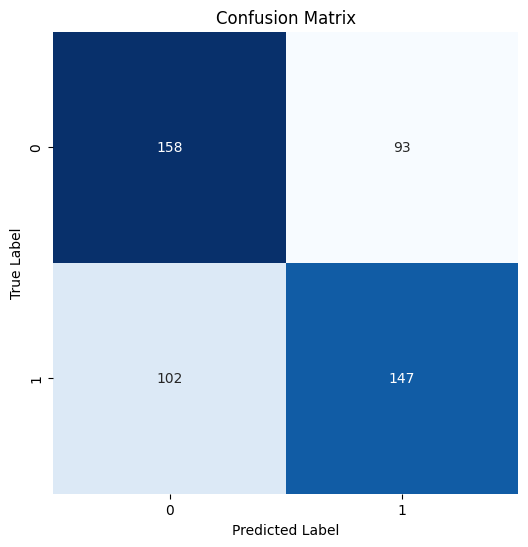

In [23]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [34]:
import pandas as pd

report_dict = classification_report(y_test, y_pred, target_names=['Cat', 'Dog'], output_dict=True)

# Convert the dictionary to a DataFrame
class_rep = pd.DataFrame(report_dict).transpose()

print("Classification Report:")
class_rep

Classification Report:


,precision,recall,f1-score,support
Cat,0.607692,0.629482,0.618395,251.00
Dog,0.612500,0.590361,0.601227,249.00
accuracy,0.610000,0.610000,0.610000,0.61
macro avg,0.610096,0.609922,0.609811,500.00
weighted avg,0.610087,0.610000,0.609845,500.00


from matplotlib import pyplot as plt
class_rep['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
class_rep['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
class_rep['f1-score'].plot(kind='hist', bins=20, title='f1-score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
class_rep['support'].plot(kind='hist', bins=20, title='support')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
class_rep.plot(kind='scatter', x='precision', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
class_rep.plot(kind='scatter', x='recall', y='f1-score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
class_rep.plot(kind='scatter', x='f1-score', y='support', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
class_rep['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
class_rep['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
class_rep['f1-score'].plot(kind='line', figsize=(8, 4), title='f1-score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
class_rep['support'].plot(kind='line', figsize=(8, 4), title='support')
plt.gca().spines[['top', 'right']].set_visible(False)

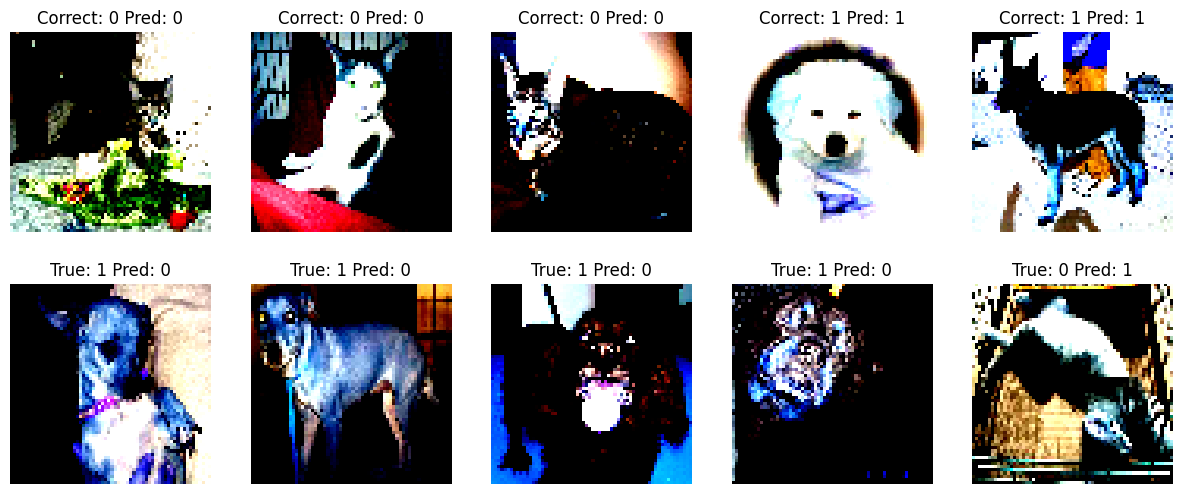

In [65]:
def plot_samples(X, y_true, y_pred, img_size, n=5):
    plt.figure(figsize=(15, 6))

    # Ensure image data is within the valid range
    #X = np.clip(X, 0, 255)  # If X contains integer pixel values
    X = np.clip(X, 0, 1)    # Uncomment this if X contains float pixel values
    X = X.astype(np.float32)  # Ensure data type is float32

    correct = np.where(y_true == y_pred)[0]
    incorrect = np.where(y_true != y_pred)[0]

    # Plot correct predictions
    for i, idx in enumerate(correct[:n]):
        img = X[idx].reshape(img_size, img_size, 3)
        plt.subplot(2, n, i+1)
        plt.imshow(img)
        plt.title(f"Correct: {y_true[idx]} Pred: {y_pred[idx]}")
        plt.axis('off')

    # Plot incorrect predictions
    for i, idx in enumerate(incorrect[:n]):
        img = X[idx].reshape(img_size, img_size, 3)
        plt.subplot(2, n, n+i+1)
        plt.imshow(img)
        plt.title(f"True: {y_true[idx]} Pred: {y_pred[idx]}")
        plt.axis('off')

    plt.show()

# Example usage
plot_samples(X_test, y_test, y_pred, img_size=img_size, n=5)

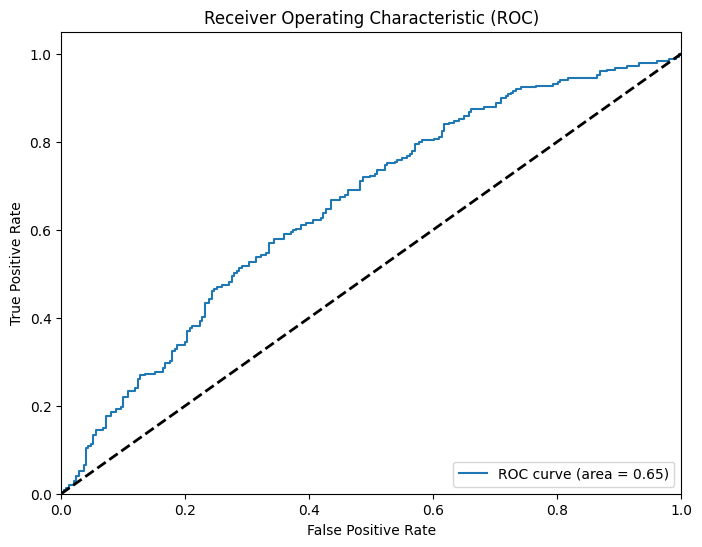

In [37]:
y_score = svm_model.decision_function(X_test_pca)

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [46]:
subset_size = 2500  # Number of images to sample

def load_images(directory, subset_size=None):
    images = []
    filenames = [f for f in os.listdir(directory) if f.endswith('.jpg')]
    if subset_size:
        filenames = np.random.choice(filenames, size=subset_size, replace=False)

    for filename in filenames:
        img = cv2.imread(os.path.join(directory, filename))
        img = cv2.resize(img, (img_size, img_size))
        images.append(img)

    return np.array(images)

# Load and prepare a subset of the external test dataset
X_test_external = load_images('/content/dogs_vs_cats/content/dogs_vs_cats/test1.zip/test1', subset_size=subset_size)
X_test_external = X_test_external / 255.0
X_test_external = X_test_external.reshape(X_test_external.shape[0], -1)  # Flatten for SVM

# Apply the same scaler and PCA used during training
X_test_external = scaler.transform(X_test_external)
X_test_external = pca.transform(X_test_external)

# Proceed with prediction
y_test_external_pred = svm_model.predict(X_test_external)

In [42]:
print(f"Number of filenames: {len(filenames_external)}")
print(f"Number of predictions: {len(y_pred_external)}")
print(f"Number of images loaded: {X_test_external.shape[0]}")

Number of filenames: 12500
Number of predictions: 2500
Number of images loaded: 2500


In [49]:
# Predict on external test dataset
y_pred_external = svm_model.predict(X_test_external)

print("Predictions for external test dataset:")
print(y_pred_external)

# Retrieve all filenames
all_filenames = [f for f in os.listdir('/content/dogs_vs_cats/content/dogs_vs_cats/test1.zip/test1') if f.endswith(".jpg")]

# Ensure the number of filenames matches the number of predictions
# Use only the first `len(y_pred_external)` filenames
filenames_external = all_filenames[:len(y_pred_external)]

# Create DataFrame
results_df = pd.DataFrame({
    'filename': filenames_external,
    'prediction': y_pred_external
})

results_df.head()

Predictions for external test dataset:
[1 0 0 ... 0 0 1]


,filename,prediction
0,5159.jpg,1
1,8414.jpg,0
2,2243.jpg,0
3,9482.jpg,1
4,3995.jpg,0


from matplotlib import pyplot as plt
_df_0['prediction'].plot(kind='hist', bins=20, title='prediction')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('filename').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['prediction'].plot(kind='line', figsize=(8, 4), title='prediction')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_3['filename'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_3, x='prediction', y='filename', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

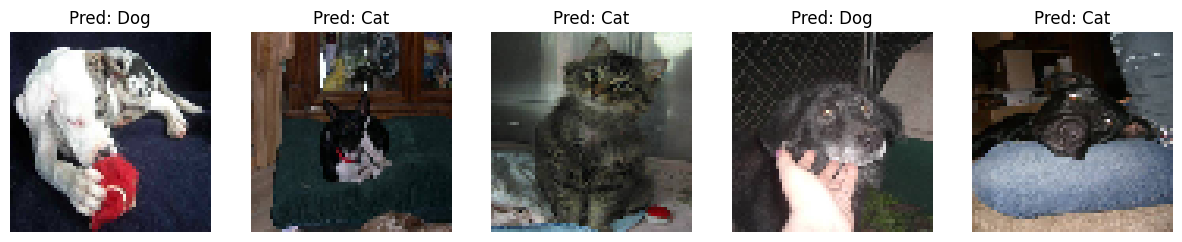

In [59]:
# Define the plot function
def plot_predictions(X, y_pred, n=5):
    plt.figure(figsize=(15, 6))
    for i in range(min(n, len(y_pred))):
        img = X[i]  # No need to reshape, as it's already in the correct shape
        plt.subplot(1, n, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert color if needed
        plt.title(f"Pred: {'Dog' if y_pred[i] == 1 else 'Cat'}")
        plt.axis('off')
    plt.show()

# Plot predictions
plot_predictions(X_test_external_images, y_pred_external, n=5)